In [152]:
options(repr.plot.width=20, repr.plot.height=10)  # Ajuste dos gráficos
options(warn=-1)

Instalando e carregando as bibliotecas utilizadas

In [153]:
library(pacman)
p_load(ggplot2,forecast,dlm,numDeriv,plotly)

Carregando as funções auxiliares, que não podem ser mostras aqui ainda

In [154]:
source('funcoes_auxiliares.R')

## Modelo MNL

Simulando o y conforme a minha função do Trabalho 1:

In [155]:
y_mnl <- simul_y_mnl(T=100,10,0.5,n_seed=1)

Utilizando o StructTs para estimar os hyperparâmetros via MLE:

In [156]:
fit <- StructTS(y_mnl, "level")

Sem usar a função de simulação

In [157]:
dados <- readRDS("dados.rds")
fit <- StructTS(dados$vetor1, "level")

Criando um dataframe com o tempo (1:T), a série simulada e o nível ajustado:

In [158]:
df <- data.frame(
  time = 1:length(y_mnl),
  observed = y_mnl,
  estimated_level = fitted(fit)[, "level"]
)

Utilizando o objeto 'fit' , podemos extrair as estimativas para os hyperparâmetros:

In [159]:
# Extract estimated variances
sigma2_epsilon <- fit$coef["epsilon"]
sigma2_eta <- fit$coef["level"]

Podemos fazer o gráfico do nível estimado contra a série simulada utilizando o ggplot2

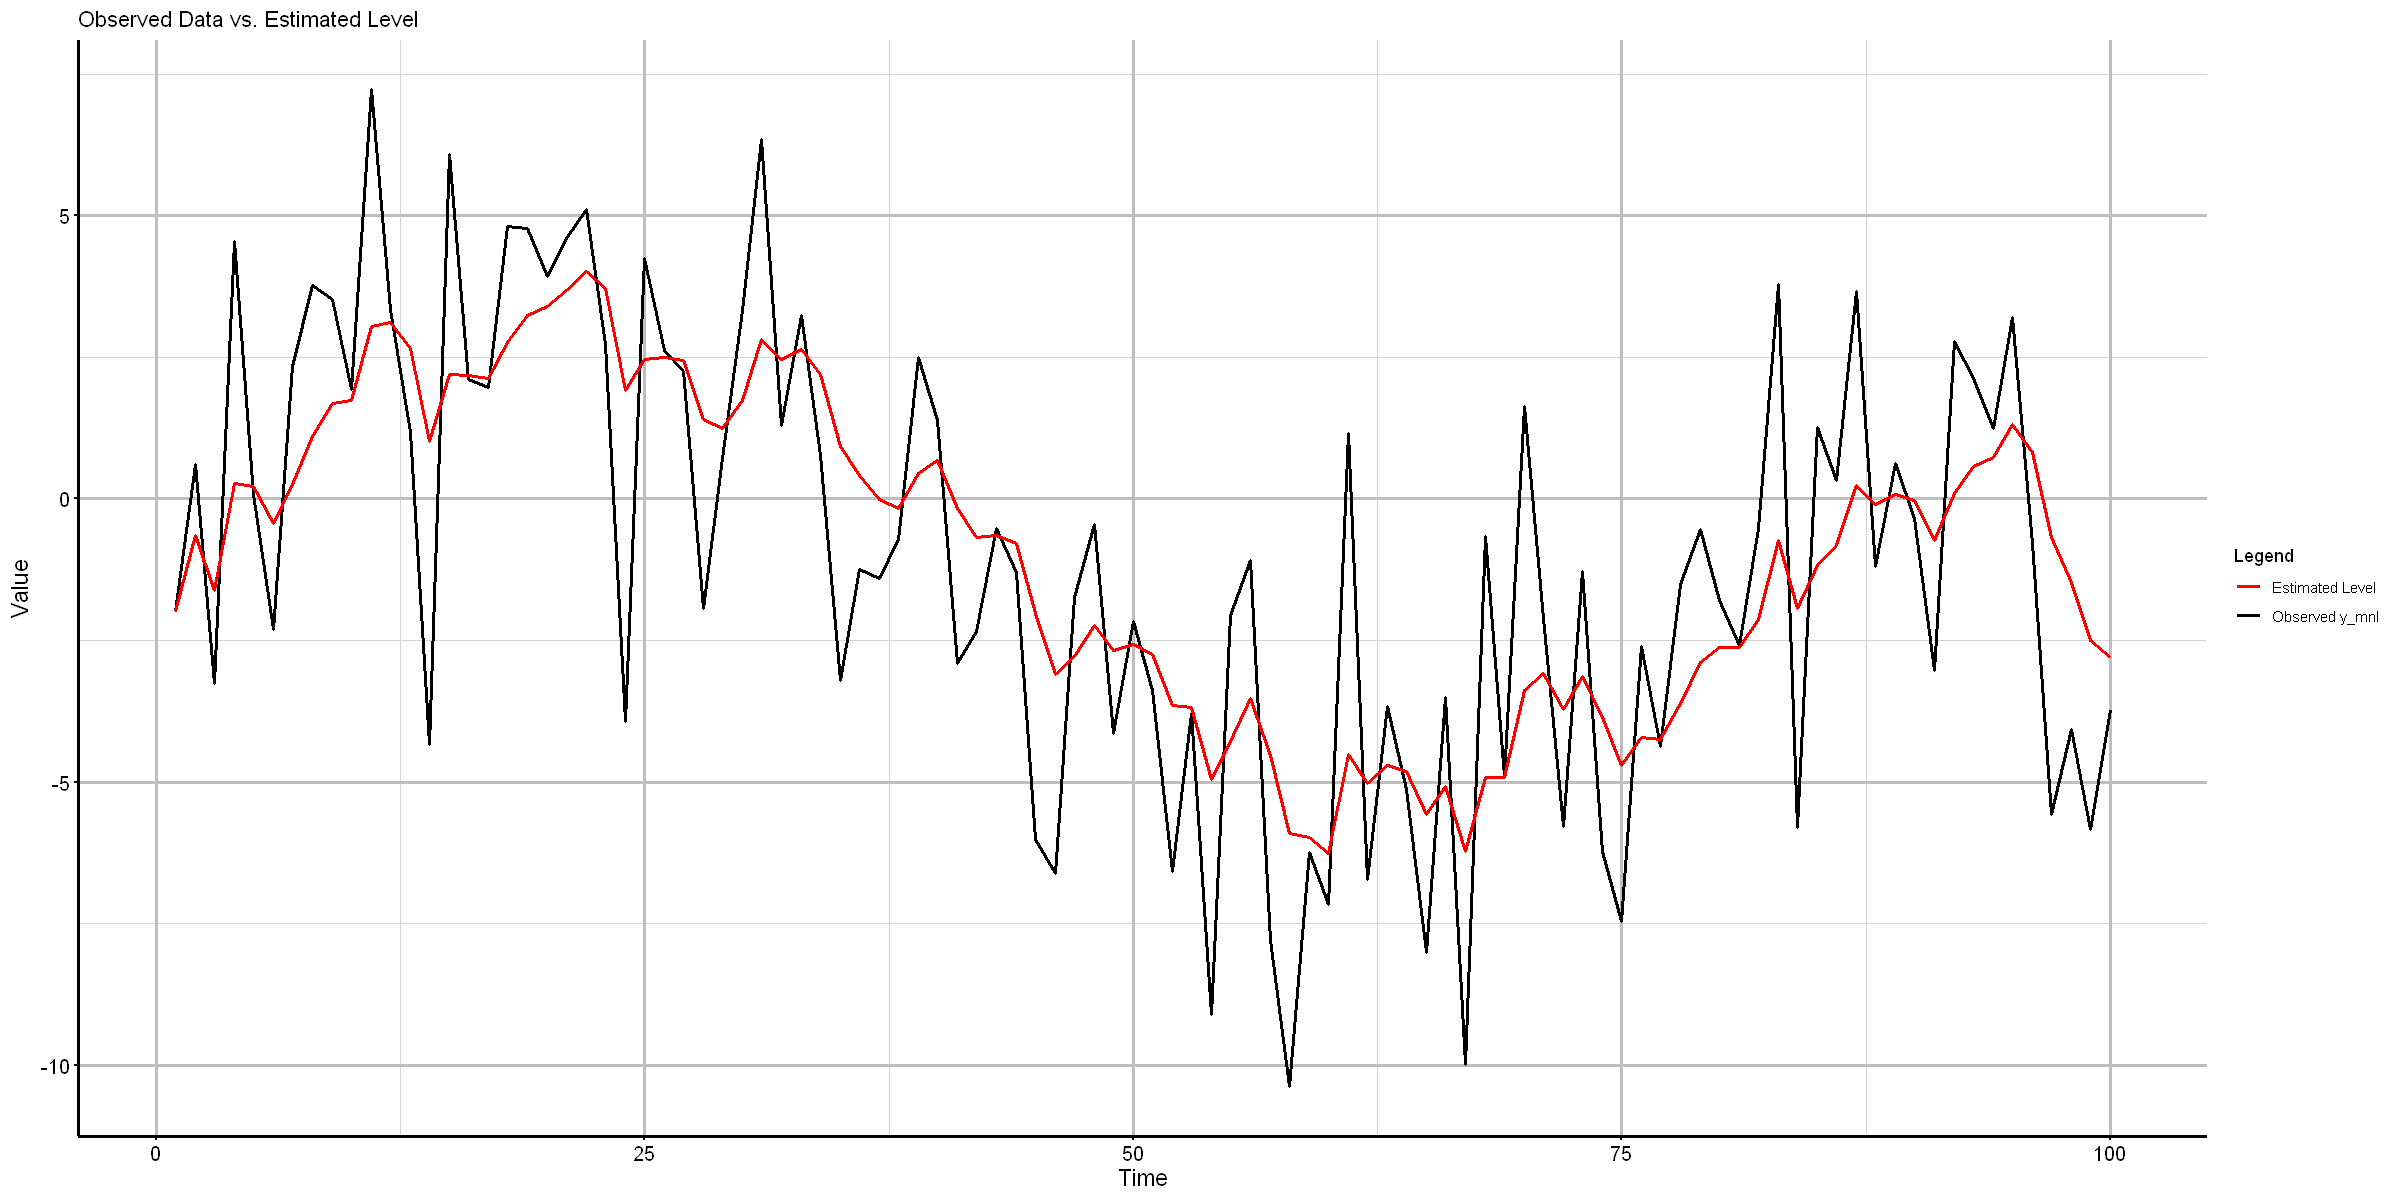

In [160]:
ggplot() + 
geom_line(data=df,aes(y = observed,x = time, color = "Observed y_mnl"), linewidth = 1) +
geom_line(data=df,aes(y = estimated_level,x = time, color = "Estimated Level"), linewidth = 1) +
scale_color_manual(values = c("Observed y_mnl" = "black", "Estimated Level" = "red")) +
labs(
title = "Observed Data vs. Estimated Level",
x = "Time",
y = "Value",
color = "Legend"
) +
  
theme_minimal()+

theme(
    panel.grid.major = element_line(color = "gray", linewidth = 1),
    panel.grid.minor = element_line(color = "lightgray", linewidth = 0.5),
    axis.line = element_line(color = "black", linewidth = 1),  # Make axis lines thicker and black
    axis.ticks = element_line(color = "black", linewidth = 0.8),  # Make ticks more visible
    axis.text = element_text(size = 12, color = "black"),  # Adjust axis text size and color
    axis.title = element_text(size = 14, color = "black")  # Adjust axis title size and color
    )




Recuperando o valor dos hyperparâmetros:

In [161]:
# Print estimated variances
cat("Estimated Observation Noise Variance (sigma^2_epsilon):", sigma2_epsilon, "\n")
cat("Estimated State Noise Variance (sigma^2_eta):", sigma2_eta, "\n")

Estimated Observation Noise Variance (sigma^2_epsilon): 7.7368 
Estimated State Noise Variance (sigma^2_eta): 0.5600975 


Será que o estimador MLE é consistente? Vamos aumentar o T e ver se as estimativas melhoram.

In [162]:
y_mnl <- simul_y_mnl(T=1000,10,0.5,1)

In [163]:
fit <- StructTS(y_mnl, "level")

In [164]:
df <- data.frame(
  time = 1:length(y_mnl),
  observed = y_mnl,
  estimated_level = fitted(fit)[, "level"]
)

In [165]:
sigma2_epsilon <- fit$coef["epsilon"]
sigma2_eta <- fit$coef["level"]

In [166]:
cat("Estimated Observation Noise Variance (sigma^2_epsilon):", sigma2_epsilon, "\n")
cat("Estimated State Noise Variance (sigma^2_eta):", sigma2_eta, "\n")

Estimated Observation Noise Variance (sigma^2_epsilon): 10.83406 
Estimated State Noise Variance (sigma^2_eta): 0.6076557 


Parece que com mais observações, as estimativas ficam mais próximas do valor verdadeiro.

No trabalho 1, conseguimos achar a sequencia a_t(1:T) e F_t[1:T] a partir de um chute incial para a_0 e p_0.

Pergunta: será que se usarmos essa função do trabalho 2 utilizando as variâncias estimadas, conseguimos reproduzir 
a série do nível estimado?

Novamente:

In [167]:
y_mnl <- simul_y_mnl(T=1000,1,0.5,1)

fit <- StructTS(y_mnl, "level")

Utilizando a função da questão 2 do trabalho 1:

In [168]:
fitted<-mnl_fk(T=1000,y_mnl,fit$coef["epsilon"],fit$coef["level"],a0=fit$model0$a,p0=fit$model0$P)

In [169]:
df_fitted_mnl <- data.frame(manual = fitted$a,structts=fit$fitted[,'level'])

In [170]:
tail(df_fitted_mnl)

manual    structts 
995  -12.96527 -12.96527
996  -13.12028 -13.12028
997  -13.11330 -13.11330
998  -13.16258 -13.16258
999  -13.36646 -13.36646
1000 -13.17953 -13.17953

In [171]:
head(df_fitted_mnl)

manual     structts  
1 -0.6264538 -0.6264538
2  0.3378710  0.3378710
3 -0.1941920 -0.1941920
4  0.8891581  0.8891581
5  0.7917861  0.7917861
6 -0.4389378 -0.4389378

## MTL

Definindo os parâmetros:

In [172]:
T <- 100
sigma2_epsilon <- 4
sigma2_eta <- 1   
sigma2_qsi <- 0.1
n_seed <- 42

Simulando a série:

In [173]:
y_mtl <- simul_y_mtl(T, sigma2_eta=sigma2_eta, sigma2_qsi=sigma2_qsi, sigma2_epsilon=sigma2_epsilon, n_seed=n_seed)

estimando os hyperparâmtros usando MLE. Novo argumento: 'Trend'

In [174]:
fit_mtl <- StructTS(y_mtl, "trend")

Montando um dataframe com a séries:

In [175]:
df_mtl <- data.frame(
  time = 1:T,
  observed = y_mtl,
  adjusted_level = fit_mtl$fitted[, "level"],
  adjusted_trend = fit_mtl$fitted[, "slope"]
)

Fazendo os gráficos usando ggplot2:

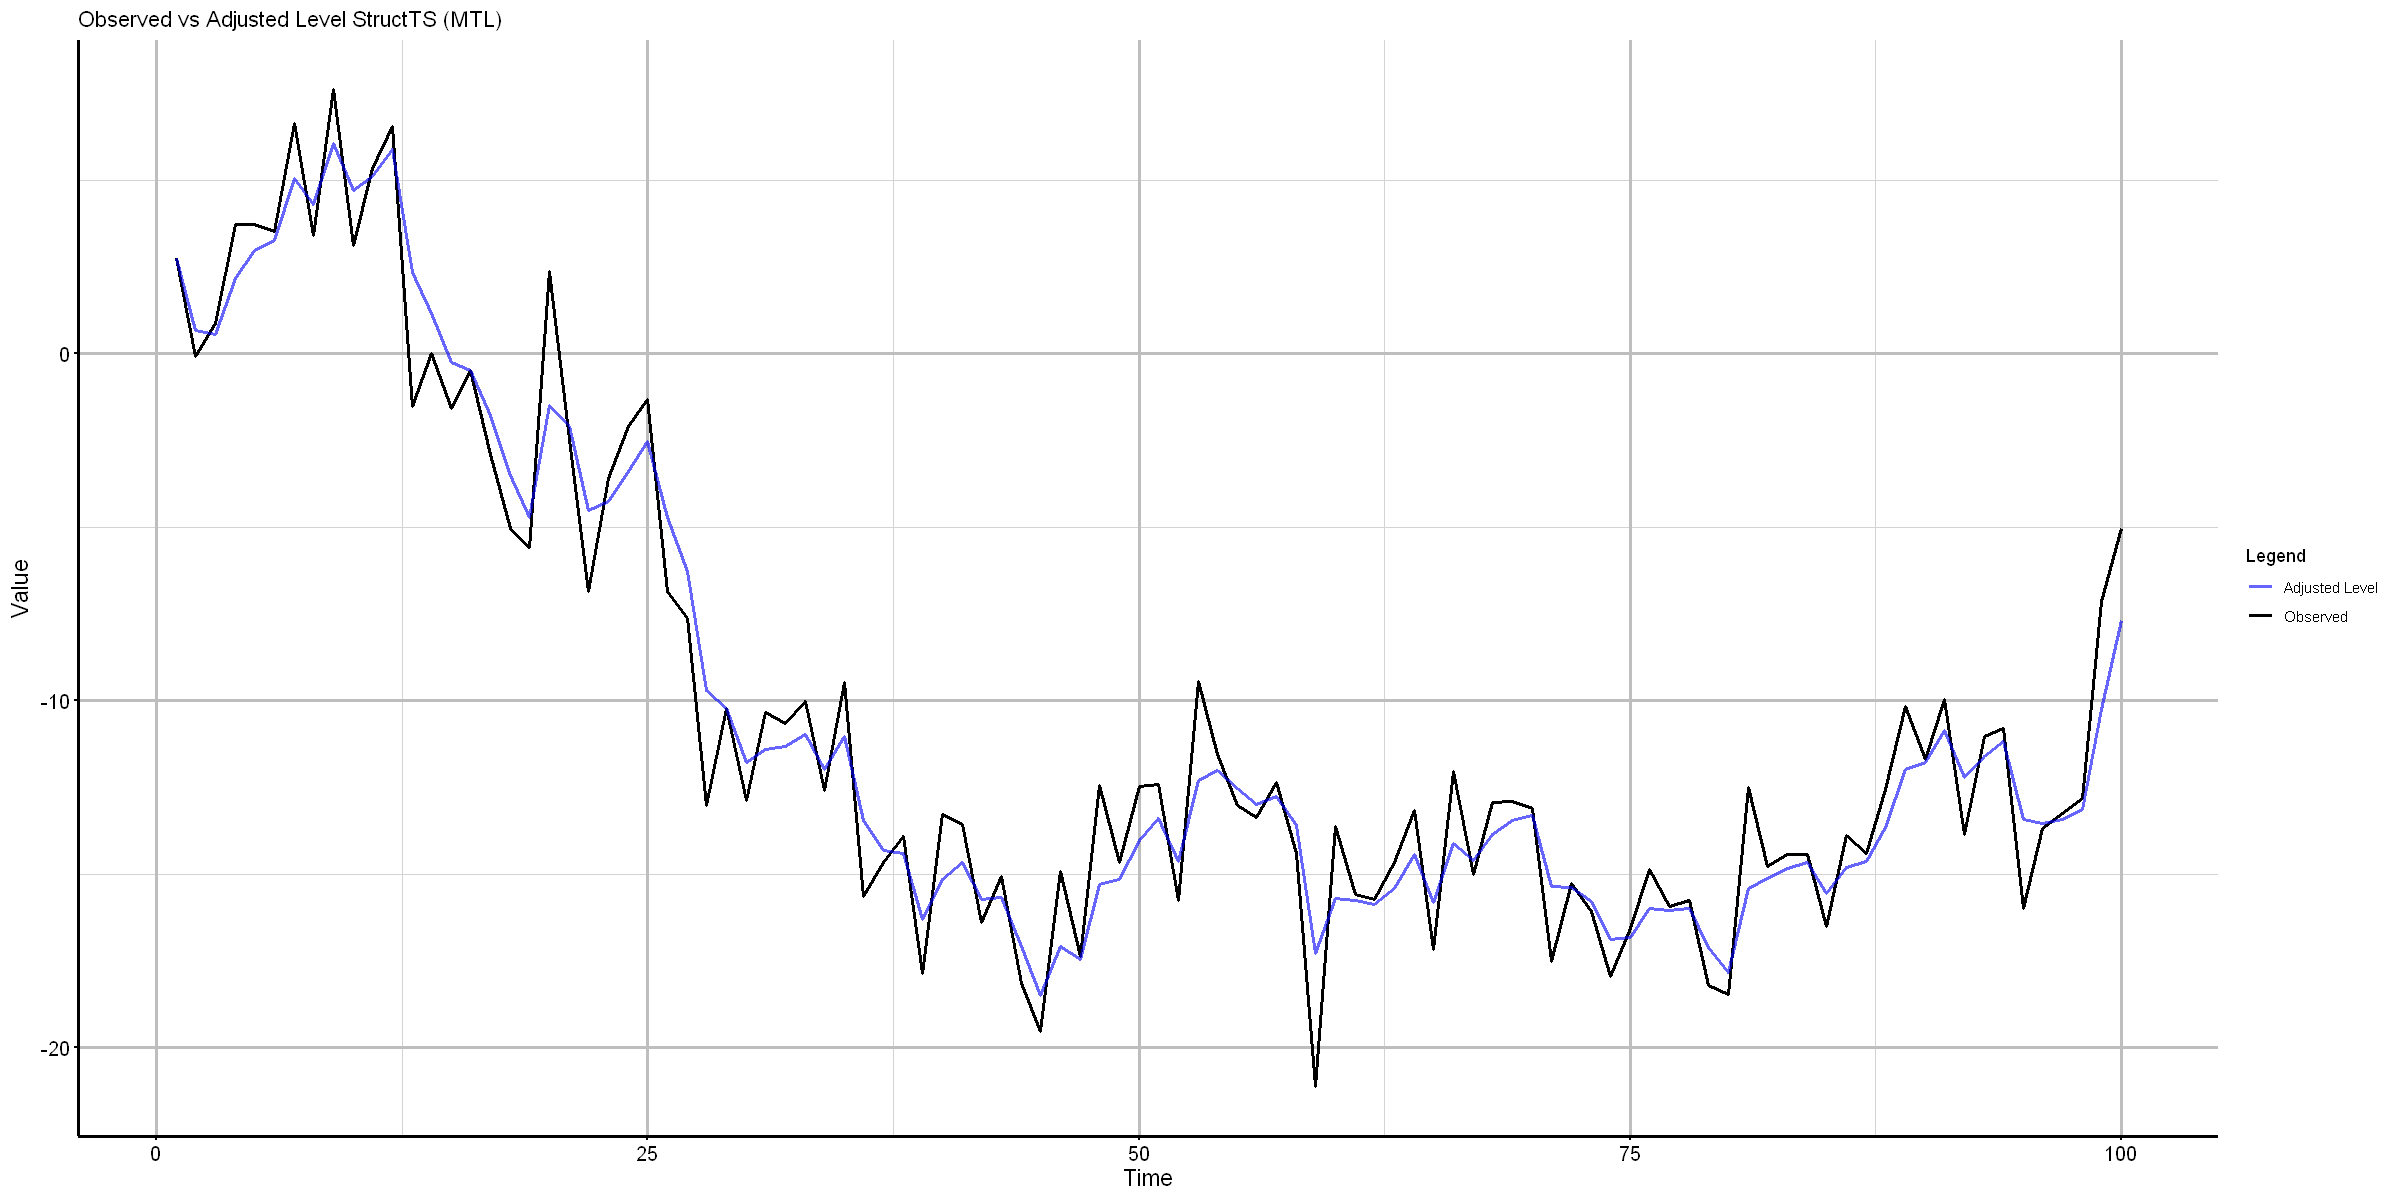

In [176]:
ggplot() +
  geom_line(data=df_mtl,aes(x = time,y = observed, color = "Observed"), size = 1) +
  geom_line(data=df_mtl,aes(x = time,y = adjusted_level, color = "Adjusted Level"), size = 1,alpha=0.6) +
  scale_color_manual(values = c("Observed" = "black", "Adjusted Level" = "blue")) +
  labs(
    title = "Observed vs Adjusted Level StructTS (MTL)",
    x = "Time",
    y = "Value",
    color = "Legend"
  ) +
  theme_minimal()+
    theme(
    panel.grid.major = element_line(color = "gray", linewidth = 1),
    panel.grid.minor = element_line(color = "lightgray", linewidth = 0.5),
    axis.line = element_line(color = "black", linewidth = 1),  # Make axis lines thicker and black
    axis.ticks = element_line(color = "black", linewidth = 0.8),  # Make ticks more visible
    axis.text = element_text(size = 12, color = "black"),  # Adjust axis text size and color
    axis.title = element_text(size = 14, color = "black")  # Adjust axis title size and color
    )

Don't know how to automatically pick scale for object of type <ts>. Defaulting to continuous.


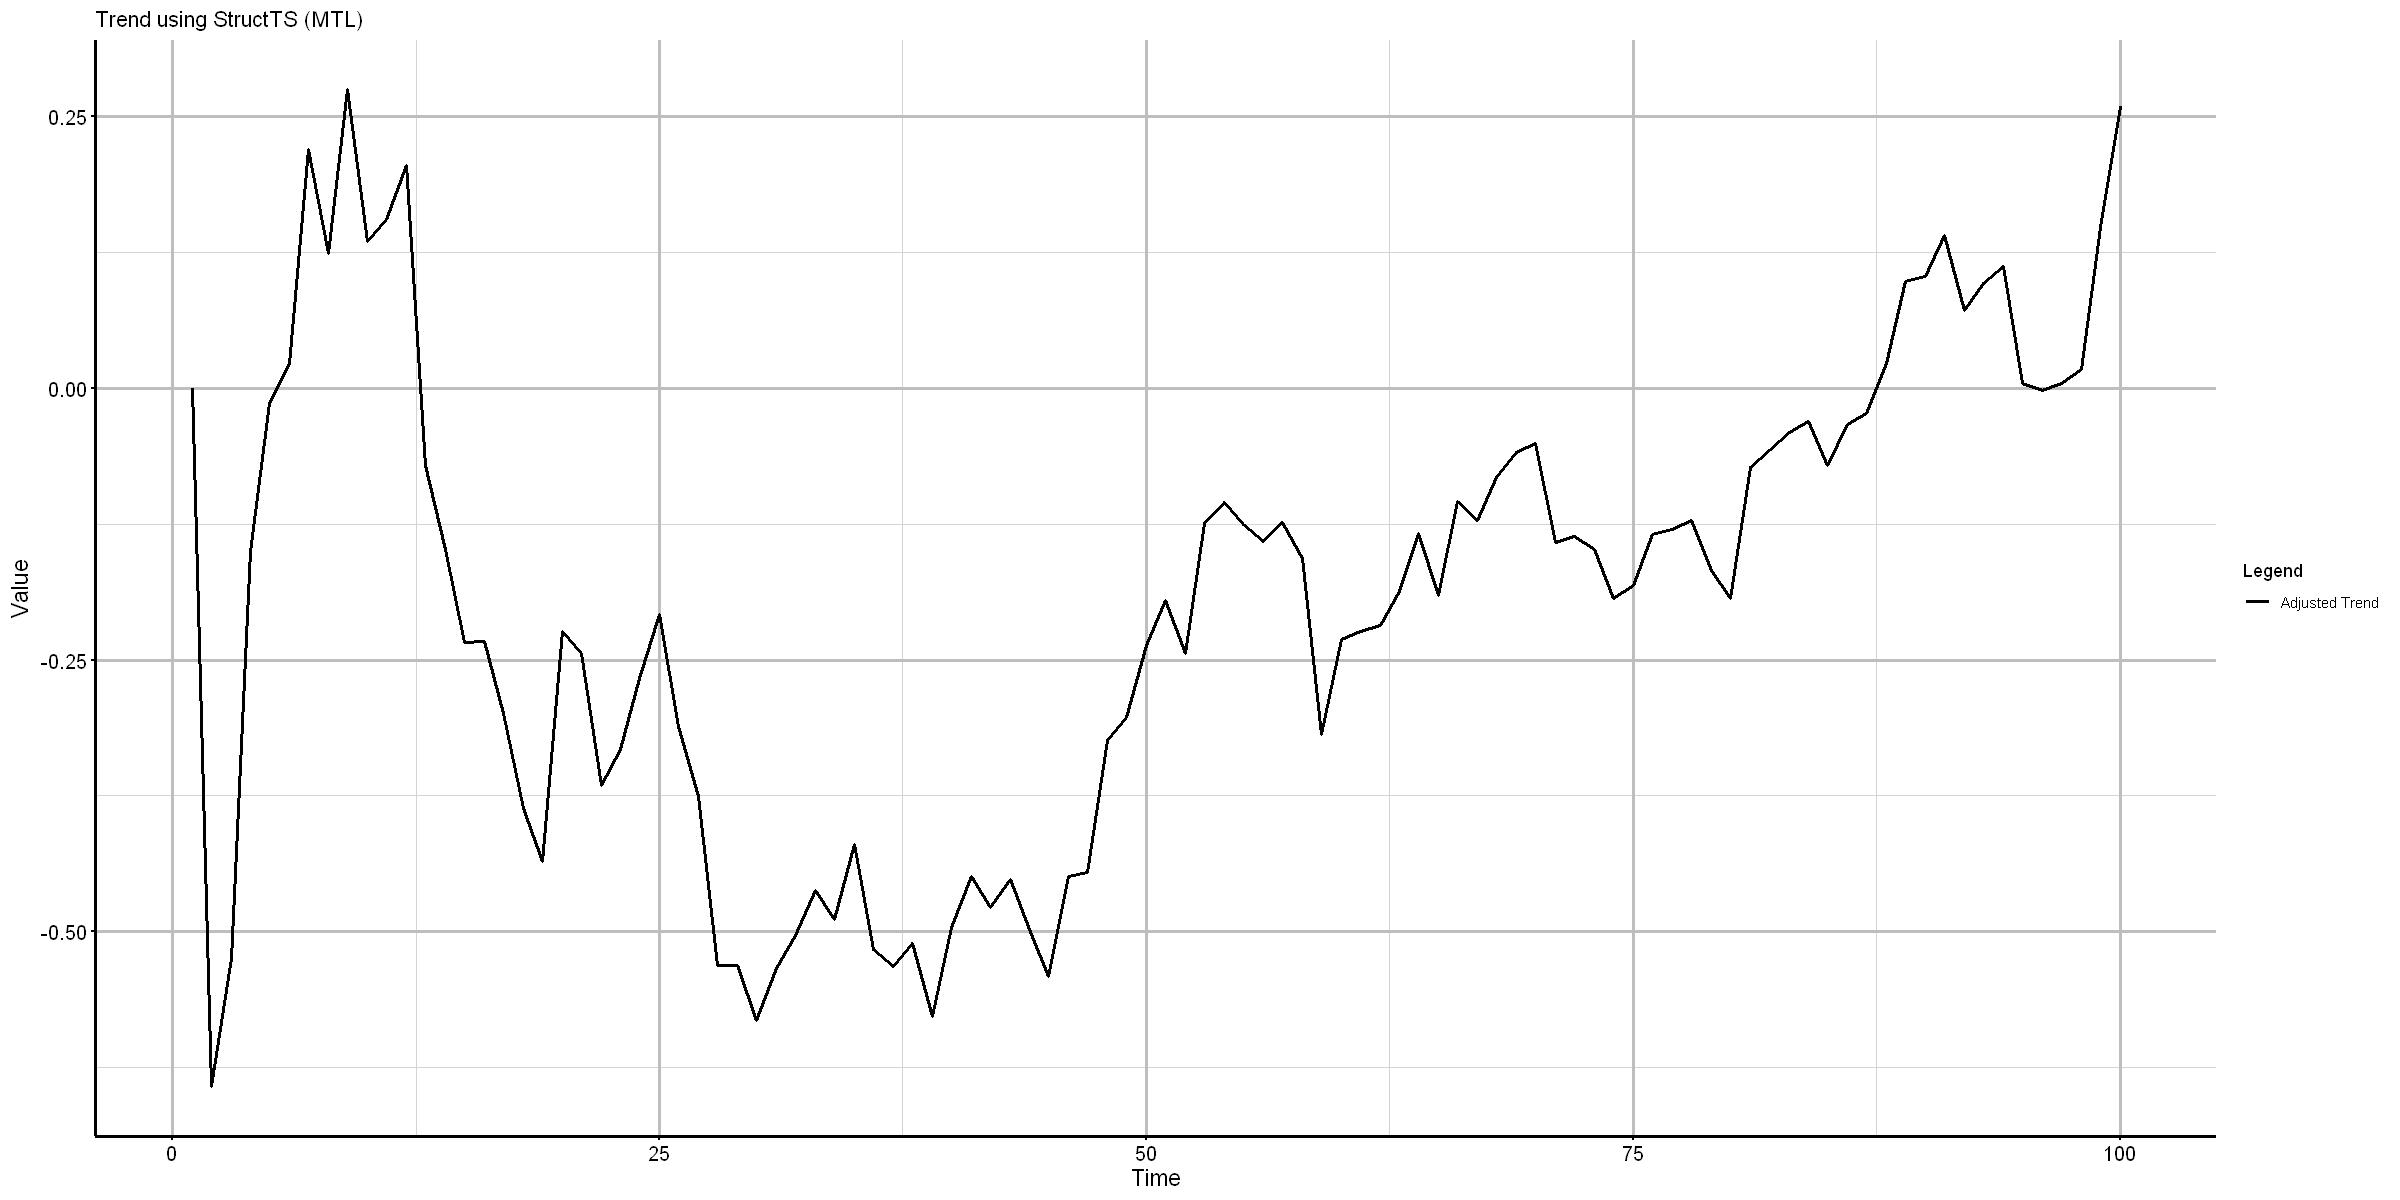

In [177]:
ggplot() +
  geom_line(data=df_mtl,aes(x = time,y = adjusted_trend, color = "Adjusted Trend"), size = 1) +
  scale_color_manual(values = c("Adjusted Trend" = "black")) +
  labs(
    title = "Trend using StructTS (MTL)",
    x = "Time",
    y = "Value",
    color = "Legend"
  ) +
  theme_minimal()+

theme(
    panel.grid.major = element_line(color = "gray", linewidth = 1),
    panel.grid.minor = element_line(color = "lightgray", linewidth = 0.5),
    axis.line = element_line(color = "black", linewidth = 1),  # Make axis lines thicker and black
    axis.ticks = element_line(color = "black", linewidth = 0.8),  # Make ticks more visible
    axis.text = element_text(size = 12, color = "black"),  # Adjust axis text size and color
    axis.title = element_text(size = 14, color = "black")  # Adjust axis title size and color
    )

Valores dos parâmetros:

In [178]:
cat("Estimated Observation Noise Variance (sigma^2_epsilon):", fit_mtl$coef["epsilon"], "\n")
cat("Estimated State Noise Variance (sigma^2_eta):", fit_mtl$coef["level"], "\n")
cat("Estimated State Noise Variance (sigma^2_qsi):", fit_mtl$coef["slope"], "\n")

Estimated Observation Noise Variance (sigma^2_epsilon): 4.028132 
Estimated State Noise Variance (sigma^2_eta): 1.495563 
Estimated State Noise Variance (sigma^2_qsi): 0.003680569 


Agora vamos fazer previsões e suavização:

In [179]:
y_mtl <- simul_y_mtl(T=100,10,0.1,1,n_seed=1)

Ajustando o modelo com StructTS

In [180]:
fit <- StructTS(y_mtl, type = "trend")

definindo o número de passos a frente:

In [181]:
h <- 20

Criando o objeto com as previsões:

In [182]:
forecast_obj <- forecast(fit, h = h, level = 90)

Fazendo a suavização

In [183]:
smoothed <- tsSmooth(fit)

Criando dataframe para o ggplot


In [184]:
df <- data.frame(
  Tempo = 1:T,
  Observado = y_mtl,
  Suavizado = smoothed[, 1]
)

In [185]:
df_pred <- data.frame(
  Tempo = (T + 1):(T + h),
  Previsao = forecast_obj$mean,
  Lower = forecast_obj$lower[, 1],
  Upper = forecast_obj$upper[, 1]
)

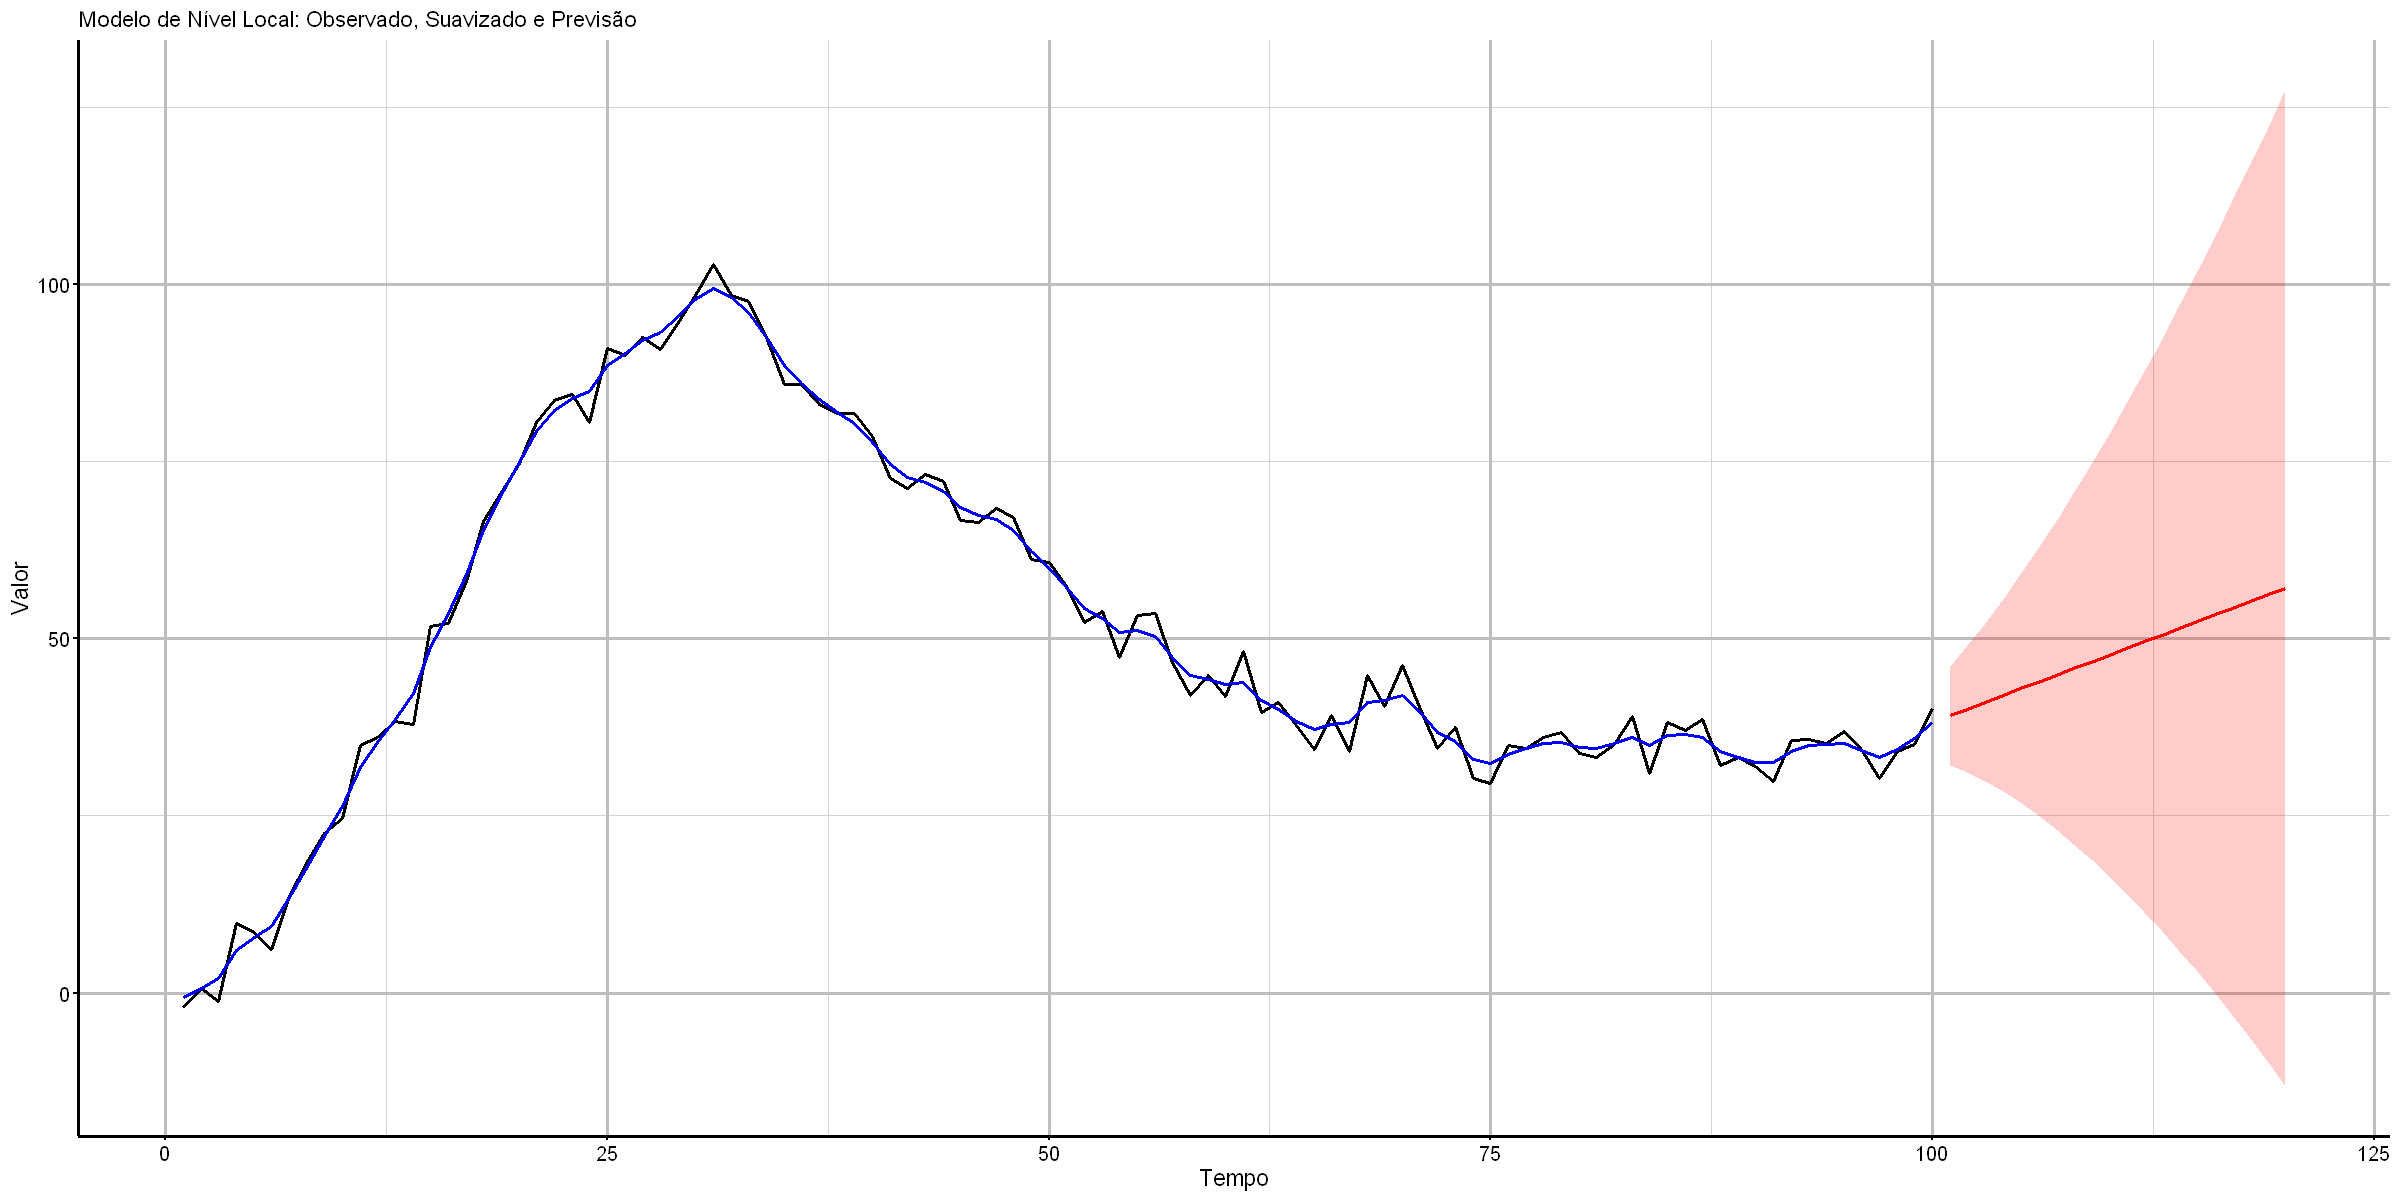

In [186]:
ggplot() +
  geom_line(data = df, aes(x = Tempo, y = Observado), color = "black", size = 1) +
  geom_line(data = df, aes(x = Tempo, y = Suavizado), color = "blue", size = 1) +
  geom_line(data = df_pred, aes(x = Tempo, y = Previsao), color = "red", size = 1) +
  geom_ribbon(data = df_pred, aes(x = Tempo, ymin = Lower, ymax = Upper), fill = "red", alpha = 0.2) +
  labs(title = "Modelo de Nível Local: Observado, Suavizado e Previsão",
       x = "Tempo", y = "Valor") +
  theme_minimal()+

theme(
    panel.grid.major = element_line(color = "gray", linewidth = 1),
    panel.grid.minor = element_line(color = "lightgray", linewidth = 0.5),
    axis.line = element_line(color = "black", linewidth = 1),  # Make axis lines thicker and black
    axis.ticks = element_line(color = "black", linewidth = 0.8),  # Make ticks more visible
    axis.text = element_text(size = 12, color = "black"),  # Adjust axis text size and color
    axis.title = element_text(size = 14, color = "black")  # Adjust axis title size and color
    )

# DLM

Como sempre fazemos :

In [187]:
T=100

In [188]:
y_mnl <- simul_y_mnl(T=T,10,0.5,1)

The function dlmModPoly in the dlm package in R creates
 a state-space model for a polynomial trend process. It helps define local level (MNL) and local trend (MTL) models 
by setting up the system matrices required for the Kalman filter.


In [189]:
build_mnl <- function(theta) {
    dlmModPoly(order = 1, dV = theta[1], dW = theta[2])
}

estimando o modelo via MLE

In [190]:
fit <- dlmMLE(y_mnl, parm = c(100, 2), build_mnl, lower = rep(1e-4, 2))

parm:Initial values for the parameters to be estimated

lower: constraint in param values

Recuperando os valores estimados dos hyperparâmetros:

In [191]:
mod_mnl <- build_mnl(fit$par)
drop(V(mod_mnl))
drop(W(mod_mnl))

[1] 7.736785

[1] 0.5601

The inverse of the Hessian matrix of the negative loglikelihood function evaluated at the
MLEs is, by standard maximum likelihood theory, an estimate of the asymptotic variance
matrix of the maximum likelihood estimators

obtendo a hessiana avaliada no MLE

In [192]:
hs <- hessian(function(x) dlmLL(y_mnl, build_mnl(x)), fit$par)

Checando se é positiva definida

In [193]:
all(eigen(hs, only.values = TRUE)$values > 0)

[1] TRUE

Calculando o Inverso da Hessiana

In [194]:
aVar <- solve(hs)

In [195]:
cat("Standard Error of dV:", sqrt(diag(aVar)[1]), "\n")
cat("Standard Error of dW:", sqrt(diag(aVar)[2]), "\n")

Standard Error of dV: 1.262764 
Standard Error of dW: 0.3122962 


Aplicando o filtro e suavização:

In [196]:
smooth_mnl <- dlmSmooth(y_mnl, mod_mnl)
filter_mnl <- dlmFilter(y_mnl,mod_mnl)

Extração dos estados suavizados

In [197]:
mu_hat <- drop(smooth_mnl$s)

Gerando as previsões com dlmForecast

In [198]:
fore_mnl <- dlmForecast(filter_mnl, nAhead = 10)

valores esperados para futuras obs

In [199]:
f <- fore_mnl$f

lista de variâncias de futuras observações

In [200]:
Q <- fore_mnl$Q

Calculando o intervalo preditivo (banda de 90%)

In [201]:
hwidth <- qnorm(0.95) * sqrt(unlist(Q))

Criando o intervalo de previsão

In [202]:
lower <- f - hwidth
upper <- f + hwidth

Criar uma data frame para facilitar o uso no ggplot2

In [203]:
df_forecast <- data.frame(
  Time = (length(y_mnl) + 1):(length(y_mnl) + 10),
  Forecasted = f,
  Lower = lower,
  Upper = upper
)

Criando o gráfico

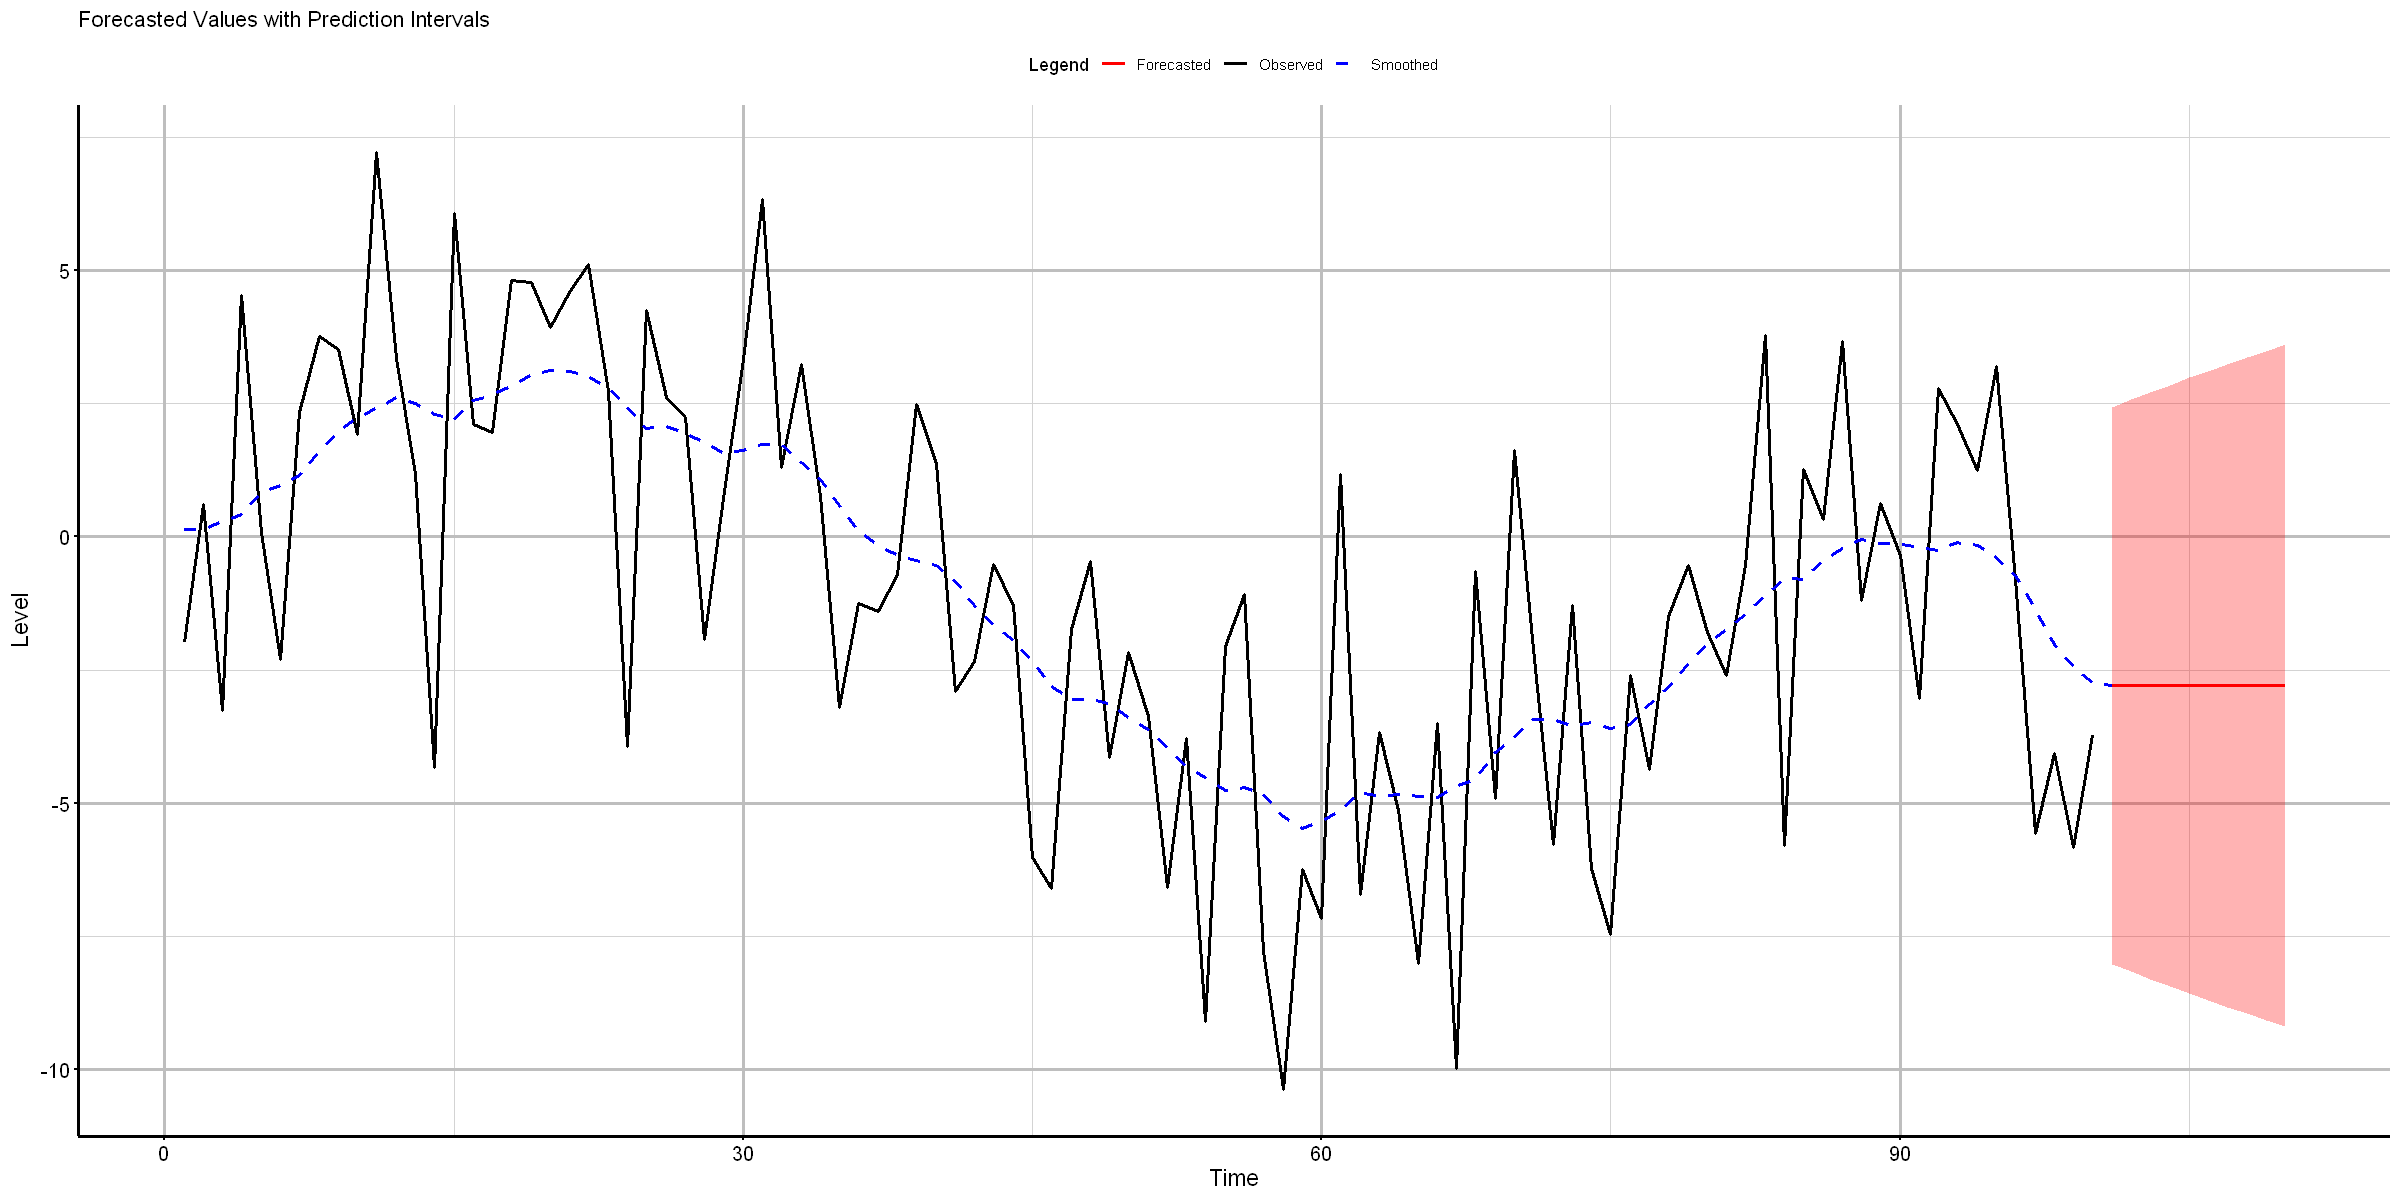

In [204]:
ggplot(df_forecast, aes(x = Time)) +
  # Adiciona as previsões como uma linha vermelha
  geom_line(aes(y = Forecasted, color = "Forecasted"), size = 1) +
  
  # Adiciona as bandas de previsão (intervalo de 50%)
  geom_ribbon(aes(ymin = Lower, ymax = Upper), fill = "red", alpha = 0.3) +
  
  # Adiciona as observações reais da série (y_mnl)
  geom_line(data = data.frame(Time = 1:length(y_mnl), Observed = y_mnl),
            aes(y = Observed, color = "Observed"), size = 1, linetype = "solid") +
  
  # Adiciona a linha de suavização (suavizado)
  geom_line(data = data.frame(Time = time(smooth_mnl$s), Smoothed = smooth_mnl$s),
            aes(y = Smoothed, color = "Smoothed"), size = 1, linetype = "dashed") +
  
  # Personalizando os eixos e título
  labs(
    title = "Forecasted Values with Prediction Intervals",
    x = "Time",
    y = "Level",
    color = "Legend"
  ) +
  
  # Customizando a paleta de cores
  scale_color_manual(values = c("Forecasted" = "red", "Observed" = "black", "Smoothed" = "blue")) +
  
  # Tema minimalista
  theme_minimal() +
    theme(
    panel.grid.major = element_line(color = "gray", linewidth = 1),
    panel.grid.minor = element_line(color = "lightgray", linewidth = 0.5),
    axis.line = element_line(color = "black", linewidth = 1),  # Make axis lines thicker and black
    axis.ticks = element_line(color = "black", linewidth = 0.8),  # Make ticks more visible
    axis.text = element_text(size = 12, color = "black"),  # Adjust axis text size and color
    axis.title = element_text(size = 14, color = "black"),  # Adjust axis title size and color
    legend.position = "top")
  

Análise dos resíduos

In [205]:
df_residual <- data.frame(resid = residuals(filter_mnl, sd = FALSE),zero=rep(0,T),tempo<-seq(1:T))

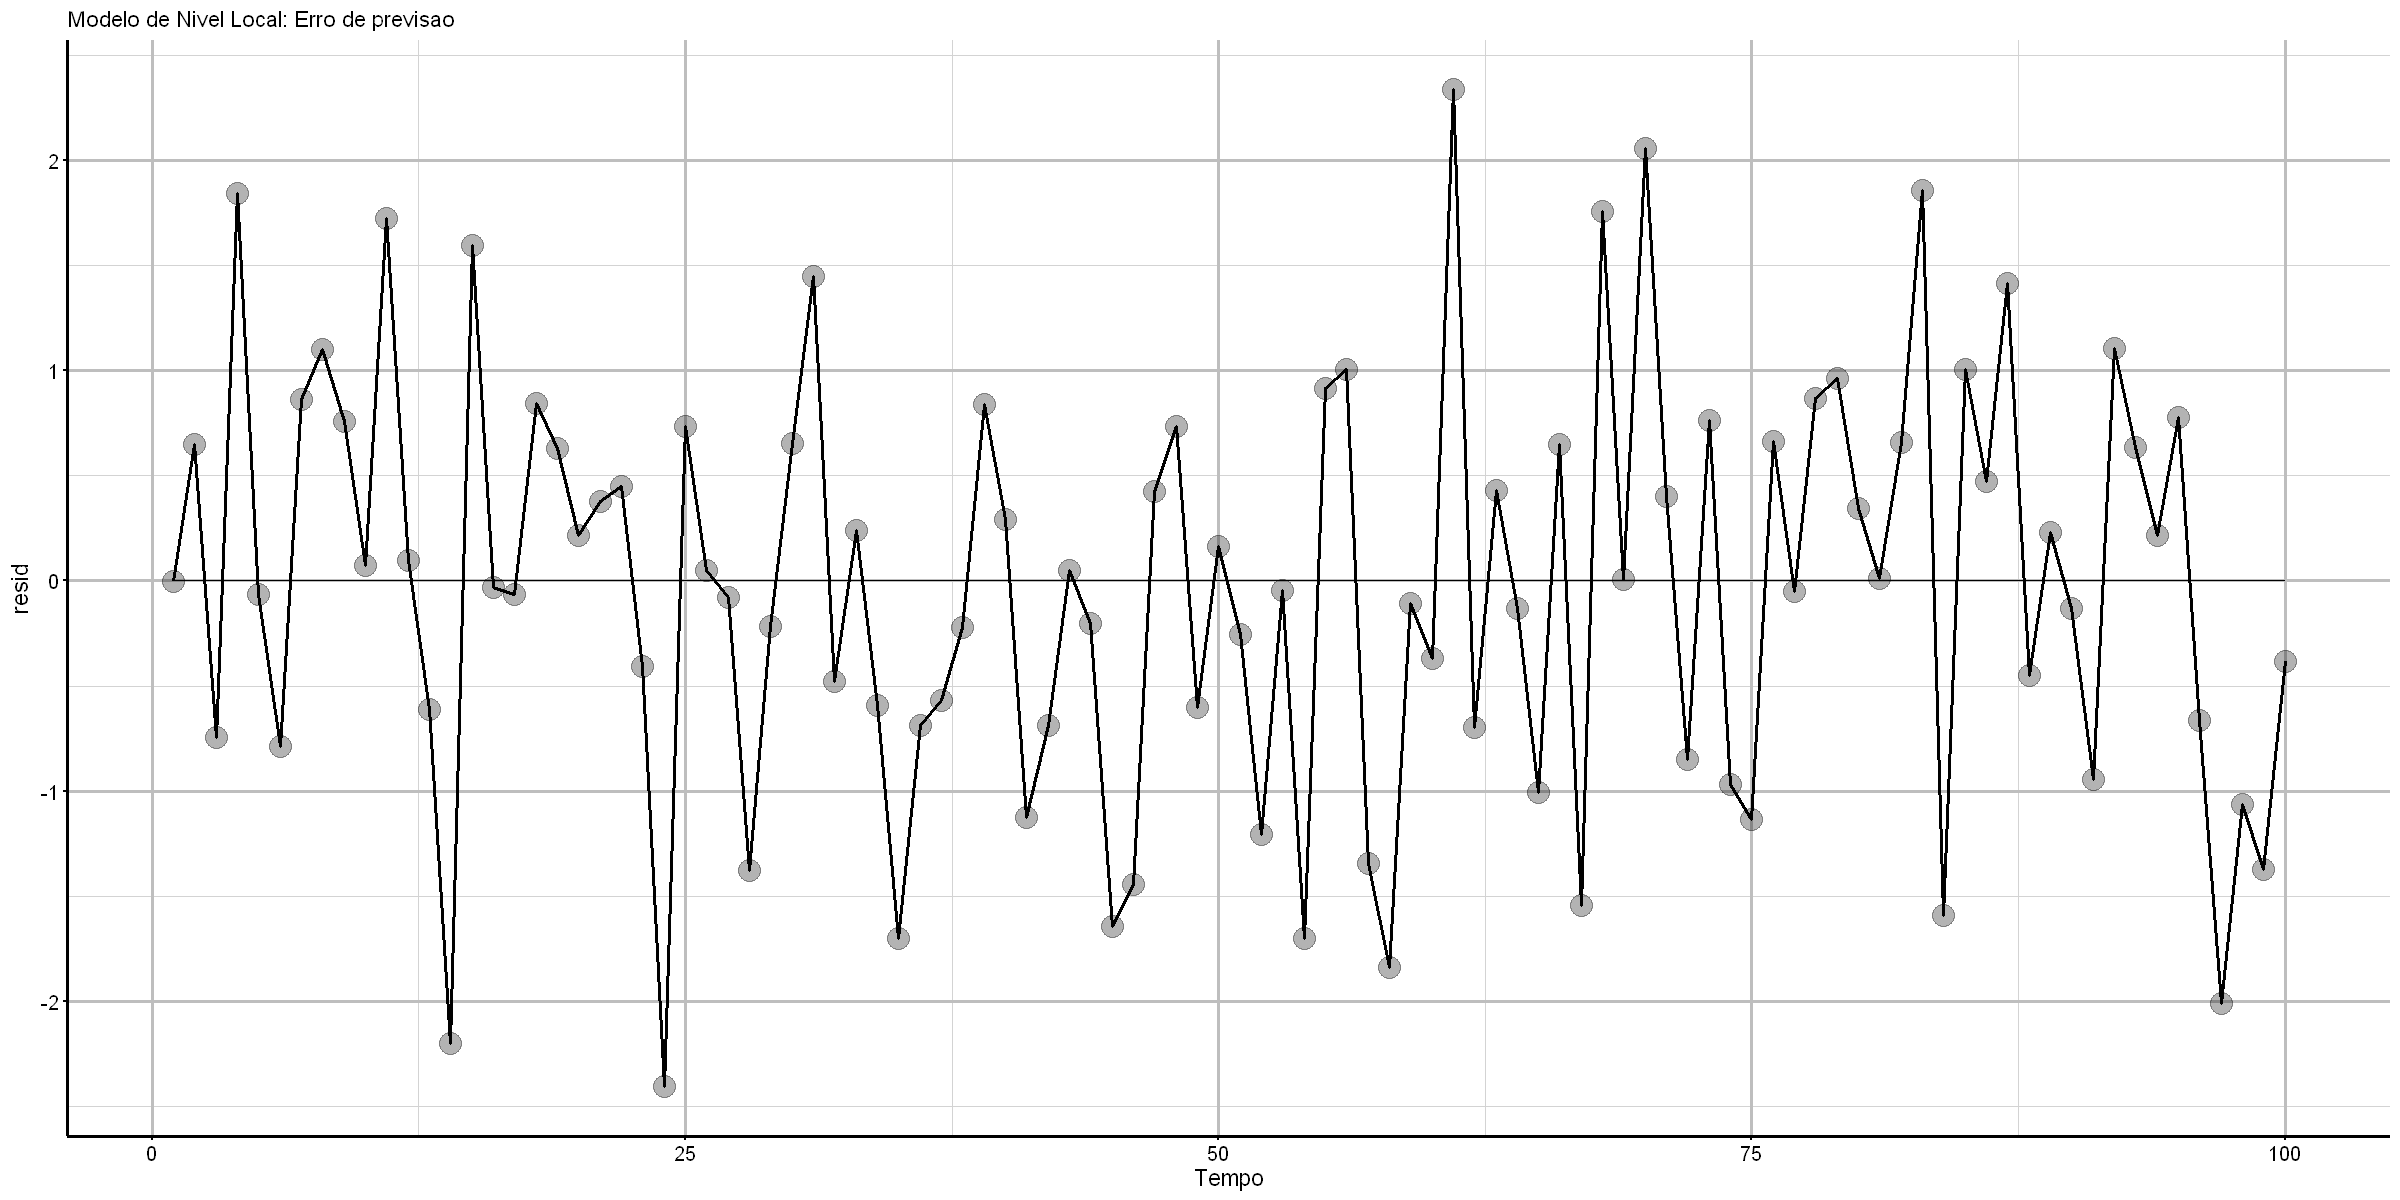

In [206]:
ggplot() +
geom_line(data = df_residual, aes(x = tempo, y = resid), color = "black", size = 1) +
geom_line(data=df_residual, aes(x=tempo,y=zero))+
geom_point(data=df_residual,aes(x = tempo , y = resid), color = "black", size = 6 ,alpha=0.3) +

labs(title = "Modelo de Nivel Local: Erro de previsao",
   x = "Tempo", y = "resid") +
theme_minimal()+
theme(panel.grid.major = element_line(color = "gray", linewidth = 1),
panel.grid.minor = element_line(color = "lightgray", linewidth = 0.5),
axis.line = element_line(color = "black", linewidth = 1),  # Make axis lines thicker and black
axis.ticks = element_line(color = "black", linewidth = 0.8),  # Make ticks more visible
axis.text = element_text(size = 12, color = "black"),  # Adjust axis text size and color
axis.title = element_text(size = 14, color = "black"))

testando se os resíduos são normais:

In [207]:
shapiro.test(df_residual$resid)
cat("media_residuos:",mean(df_residual$resid),'\n')
cat("var_residuos:",var(df_residual$resid),'\n')


	Shapiro-Wilk normality test

data:  df_residual$resid
W = 0.99154, p-value = 0.787


media_residuos: -0.02388998 
var_residuos: 0.9994234 


# Implementando a MLE

o objetivo dessa secção é comparar a estimação manual e a minha implementação de estimação

Gerando a série e fazendo a estimação usando pacote

In [208]:
T=1000
y_mnl <- simul_y_mnl(T=T,1,0.5,1)
fit <- dlmMLE(y_mnl, parm = c(100, 2), build_mnl, lower = rep(1e-4, 2))

Estimação manual

definindo o espaço paramétrico:

In [209]:
sigma_epsilon2_vals <- seq(0.1,4, length.out = 100)
sigma_eta2_vals <- seq(0.1, 4, length.out = 100)

função de verossimilhança:

In [210]:
logLik_mnl <- function(theta) {
  
  #definindo parâmetros
  sigma_epsilon2 <- theta[1]
  sigma_eta2 <- theta[2]
  
  # fazendo a filtragem usando minha função do trabalho 1
  fk_results <- mnl_fk(T = length(y_mnl),y_mnl, sigma_epsilon2, sigma_eta2, a0 = 0, p0 = 100)
  
  # extraindo (v_t) e a variância (F_t)
  v_t <- fk_results$v_t
  F_t <- fk_results$F
  
  # Computando a verossimilhança
  n <- length(y_mnl)
  logLik <- - (n / 2) * log(2 * pi) - 0.5 * sum(log(abs(F_t))) - 0.5 * sum((v_t^2) / F_t)
  
  return(logLik)
}

Calculando a verossimilhança para todas as combinações dos hyperparâmetros:

In [211]:
length(sigma_epsilon2_vals)

[1] 100

In [212]:
length(sigma_eta2_vals)

[1] 100

In [107]:
likelihood_matrix <- outer(sigma_epsilon2_vals, sigma_eta2_vals, 
                           Vectorize(function(se, sw) logLik_mnl(c(se, sw))))

In [108]:
dim(likelihood_matrix)

[1] 100 100

transformando em um df para usar o ggplot2

In [213]:
expand.grid(c(1,2),c(10,20))

Var1 Var2
1 1    10  
2 2    10  
3 1    20  
4 2    20

In [214]:
likelihood_df <- expand.grid(sigma_epsilon2 = sigma_epsilon2_vals, 
                             sigma_eta2 = sigma_eta2_vals)

adicionando a verossimilhança no df

In [215]:
likelihood_df$logLik <- as.vector(likelihood_matrix)

comparando os resultado


pacote:

In [216]:
cat("Estimated sigma^2_epsilon:", fit$par[1], "\n")
cat("Estimated sigma^2_eta:", fit$par[2], "\n")

Estimated sigma^2_epsilon: 1.074177 
Estimated sigma^2_eta: 0.5647697 


manual:

In [217]:
mle_estimates <- likelihood_df %>%
  filter(logLik == max(logLik)) %>%
  select(sigma_epsilon2, sigma_eta2, logLik)

names(mle_estimates)<-c("sigma2_epsilon",'sigma2_eta','Max LogLikelihood')

cat("Estimated sigma^2_epsilon:", unlist(mle_estimates[1]), "\n")
cat("Estimated sigma^2_eta:", unlist(mle_estimates[2]), "\n")

Estimated sigma^2_epsilon: 1.084848 
Estimated sigma^2_eta: 0.5727273 


In [218]:
fig <- plot_ly(
  x = unique(likelihood_df$sigma_epsilon2),
  y = unique(likelihood_df$sigma_eta2),     
  z = likelihood_matrix, 
  type = "surface",
  colorscale = "Inferno"
)

fig <- fig %>%
  layout(
    title = "Log-Likelihood Surface for MNL Model",
    scene = list(
      xaxis = list(title = expression(sigma[epsilon]^2)),
      yaxis = list(title = expression(sigma[eta]^2)),
      zaxis = list(title = "Log-Likelihood")
    )
  )


fig

HTML widgets cannot be represented in plain text (need html)

Heatmap:

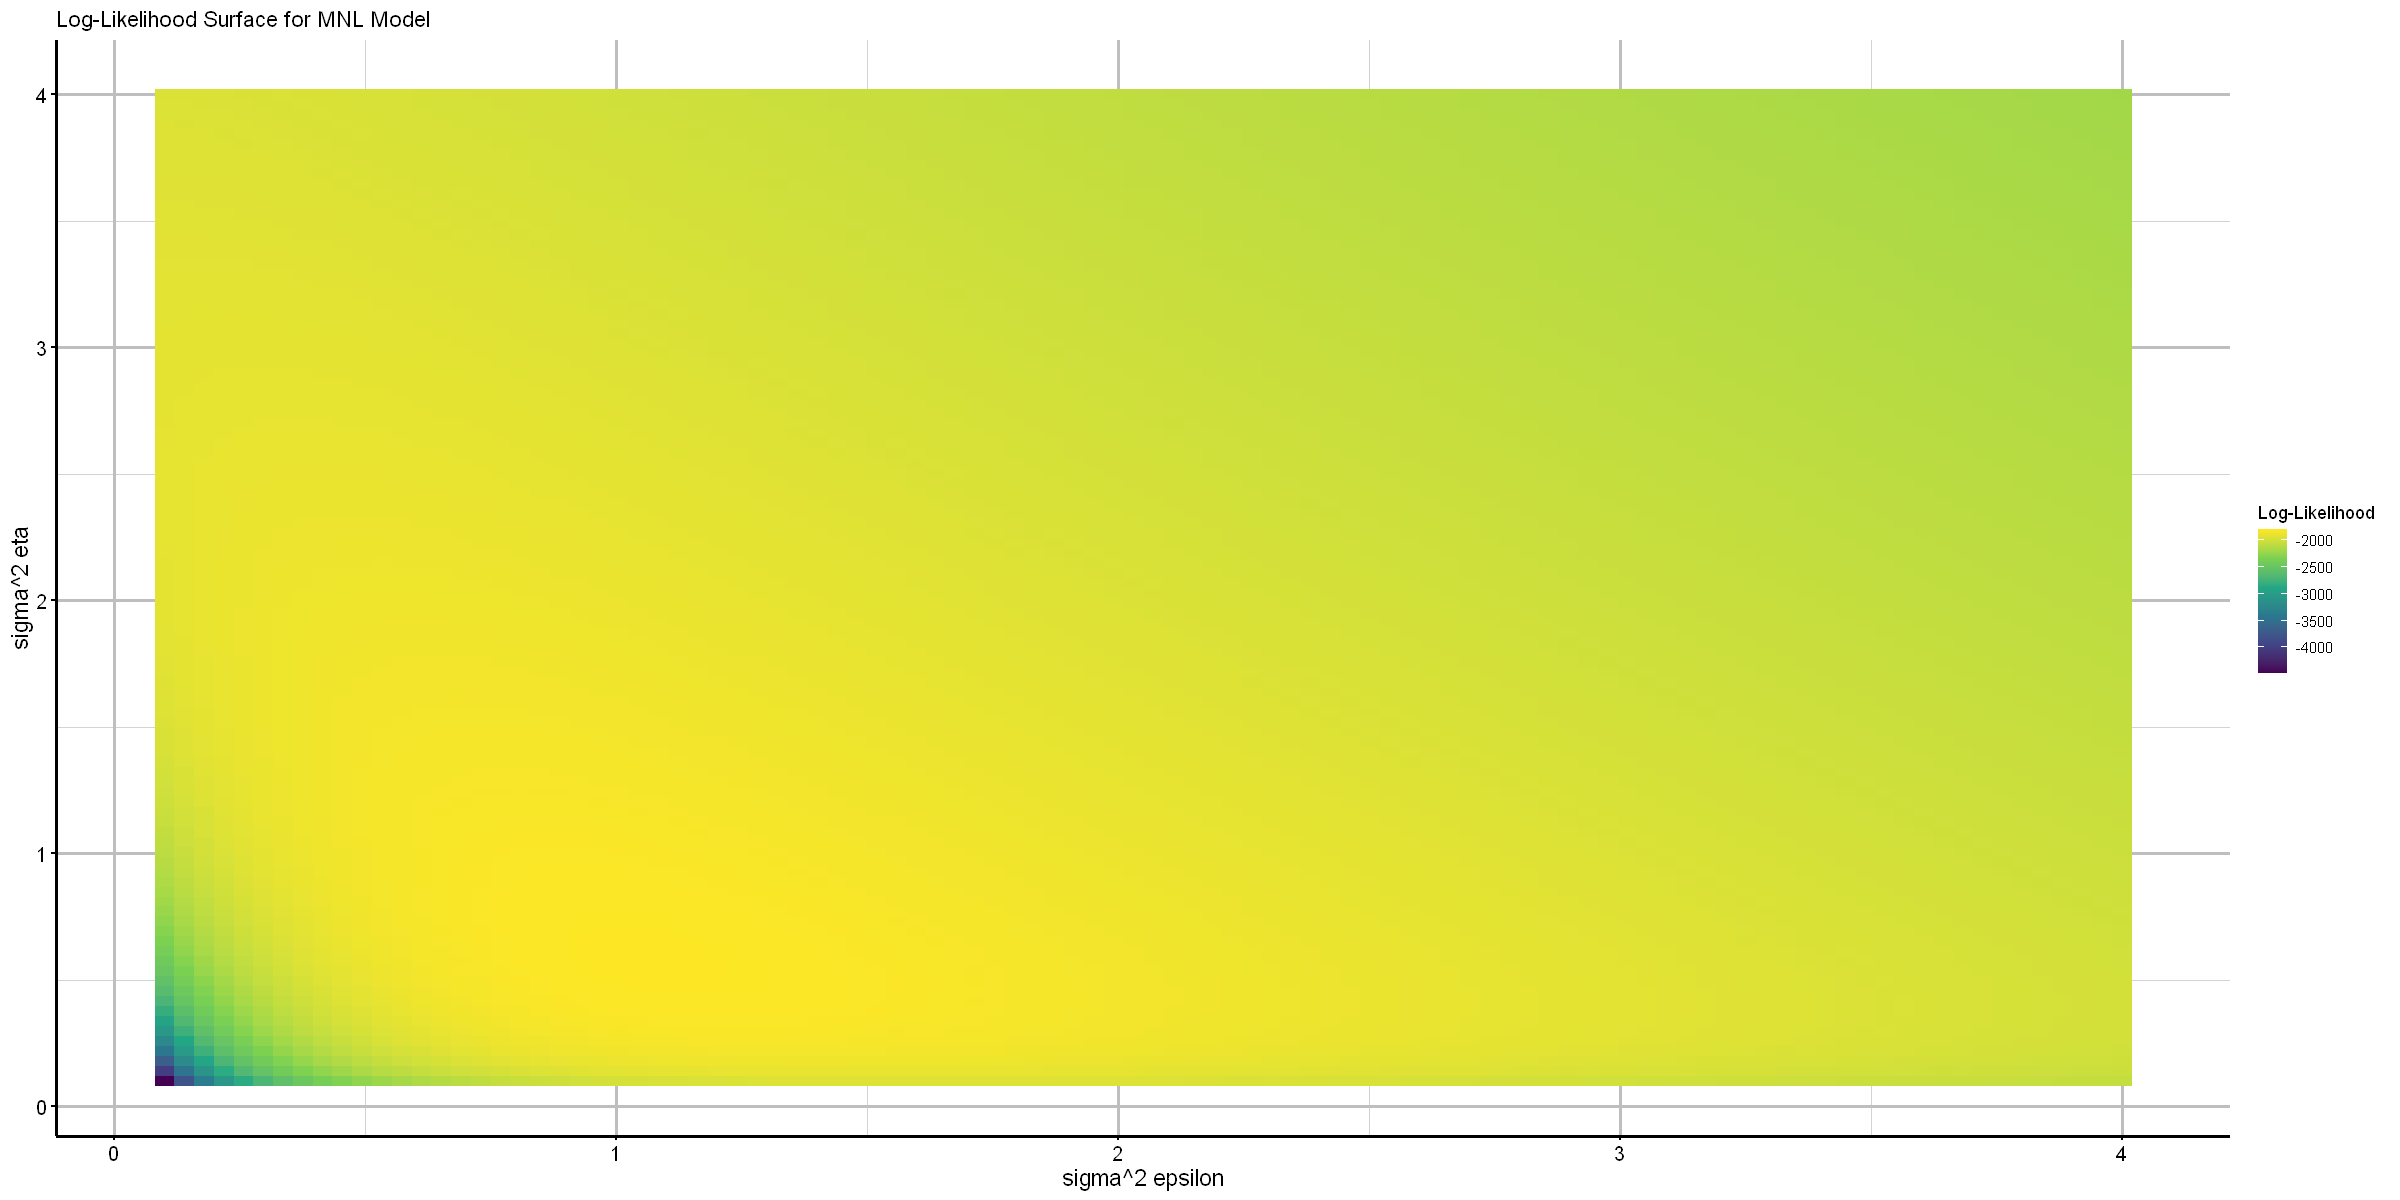

In [219]:
ggplot(likelihood_df, aes(x = sigma_epsilon2, y = sigma_eta2, fill = logLik)) +
  geom_tile() +
  scale_fill_viridis_c()+
  labs(title = "Log-Likelihood Surface for MNL Model",
       x = 'sigma^2 epsilon',
       y = 'sigma^2 eta',
       fill = "Log-Likelihood") +
      theme_minimal()+
    theme(panel.grid.major = element_line(color = "gray", linewidth = 1),
    panel.grid.minor = element_line(color = "lightgray", linewidth = 0.5),
    axis.line = element_line(color = "black", linewidth = 1),  # Make axis lines thicker and black
    axis.ticks = element_line(color = "black", linewidth = 0.8),  # Make ticks more visible
    axis.text = element_text(size = 12, color = "black"),  # Adjust axis text size and color
    axis.title = element_text(size = 14, color = "black"))

# exercícios

1) estime o modelo de nível Local utilizando a base de dados Nile ( usando StructTS e DLM) e faça o gráficos usando ggplot2.

Usando o structTS

In [220]:
fitNile <- StructTS(Nile, "level")

In [221]:
df <- data.frame(Nile_obs <- Nile,time=seq(1:length(fitNile$fitted)),estimated_level<-fitted(fitNile),smoothed<-tsSmooth(fitNile))

In [222]:
h=10

In [223]:
forecast_obj <- forecast(fitNile, h = h, level = 90)

In [224]:
T=length(fitNile$fitted)

In [225]:
df_pred<-data.frame('prev'=forecast_obj$mean,'lower'=forecast_obj$lower,'upper'=forecast_obj$upper,'time'=(T+1):(T+h))

In [226]:
colnames(df_pred)<-c('prev','lower','upper','time')

Don't know how to automatically pick scale for object of type <ts>. Defaulting to continuous.


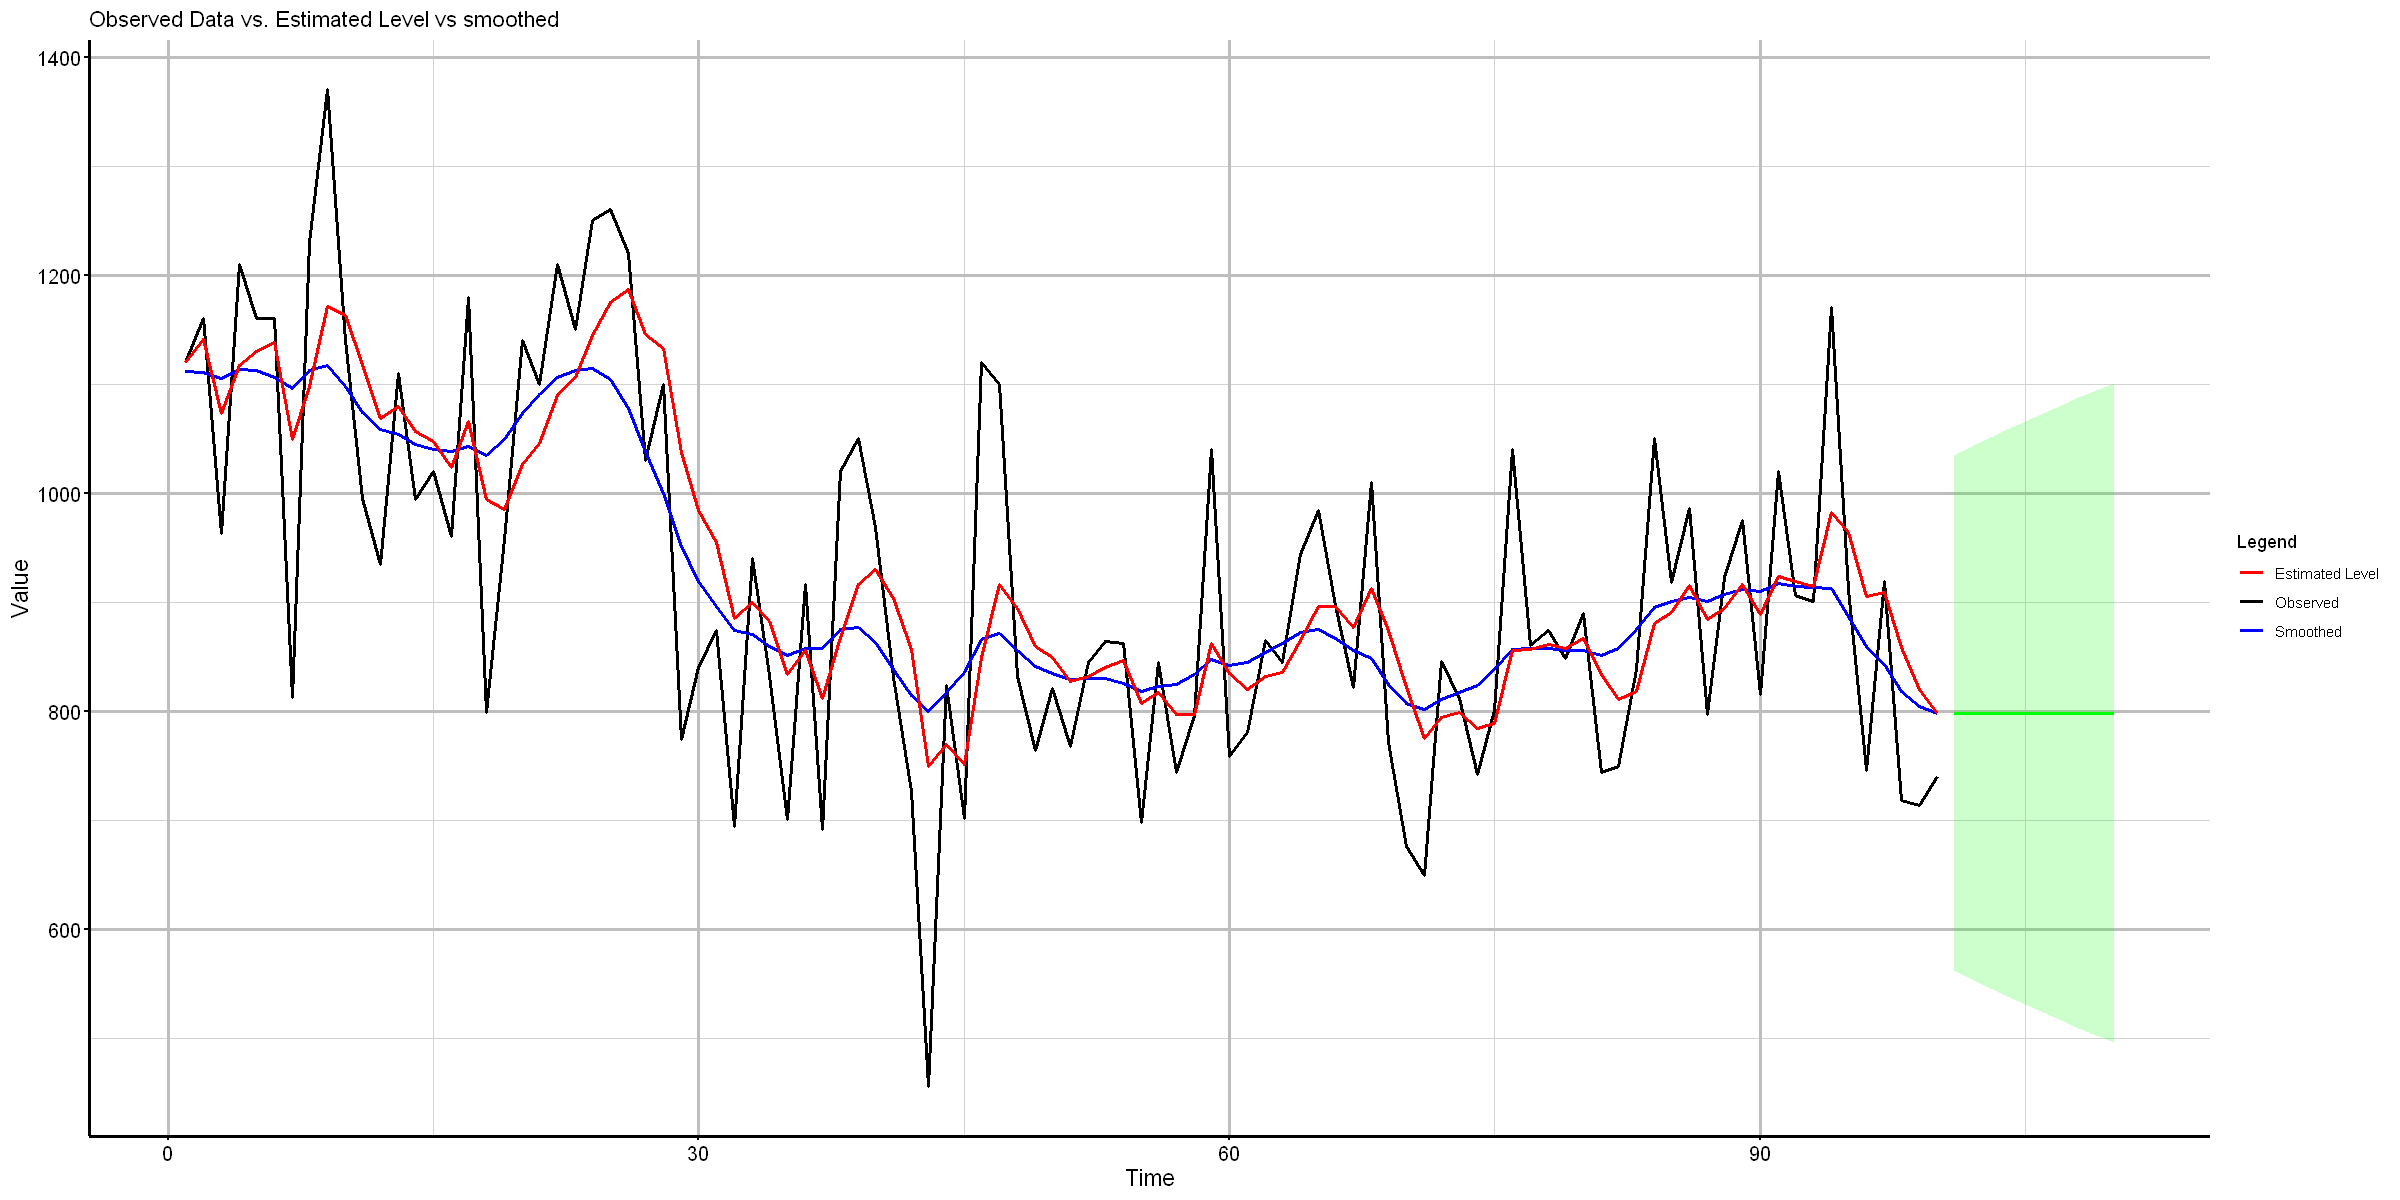

In [227]:
ggplot() + 
geom_line(data=df,aes(y = Nile_obs,x = time, color = "Observed"), linewidth = 1) +
geom_line(data=df,aes(y = smoothed,x = time, color = "Smoothed"), linewidth = 1) +
geom_line(data=df,aes(y = estimated_level,x = time, color = "Estimated Level"), linewidth = 1) +
geom_line(data = df_pred, aes(x = time, y =prev), color = "green", size = 1) +
geom_ribbon(data = df_pred, aes(x = time, ymin = lower, ymax = upper), fill = "green", alpha = 0.2)+
scale_color_manual(values = c("Observed" = "black", "Estimated Level" = "red",'Smoothed'= 'blue')) +
labs(
title = "Observed Data vs. Estimated Level vs smoothed",
x = "Time",
y = "Value",
color = "Legend"
) +
  
theme_minimal()+

theme(
    panel.grid.major = element_line(color = "gray", linewidth = 1),
    panel.grid.minor = element_line(color = "lightgray", linewidth = 0.5),
    axis.line = element_line(color = "black", linewidth = 1),  # Make axis lines thicker and black
    axis.ticks = element_line(color = "black", linewidth = 0.8),  # Make ticks more visible
    axis.text = element_text(size = 12, color = "black"),  # Adjust axis text size and color
    axis.title = element_text(size = 14, color = "black")  # Adjust axis title size and color
    )

In [228]:
print(fitNile$coef)

    level   epsilon 
 1469.147 15098.577 


agora usando o pacote dlm

In [229]:
build_states <- function(theta) {
    dlmModPoly(order = 1, dV = theta[1], dW = theta[2])
}

In [230]:
fitNile <- dlmMLE(Nile, parm = c(100, 2), build_states, lower = rep(1e-4, 2))

In [231]:
mod_Nile <- build_states(fitNile$par)
drop(V(mod_Nile))
drop(W(mod_Nile))

[1] 15099.79

[1] 1468.438

In [232]:
smooth_Nile <- dlmSmooth(Nile, mod_Nile)
filter_Nile <-dlmFilter(Nile,mod_Nile)

In [233]:
fore_Nile <- dlmForecast(filter_Nile, nAhead = 10)

In [234]:
f <- as.numeric(fore_Nile$f)
Q <- as.numeric(fore_Nile$Q)

In [235]:
hwidth <- qnorm(0.95) * sqrt(unlist(Q))

In [236]:
lower <- f - hwidth
upper <- f + hwidth

In [237]:
df_forecast <- data.frame(
  Time = (length(Nile) + 1):(length(Nile) + 10),
  Forecasted = f,
  Lower = lower,
  Upper = upper
)

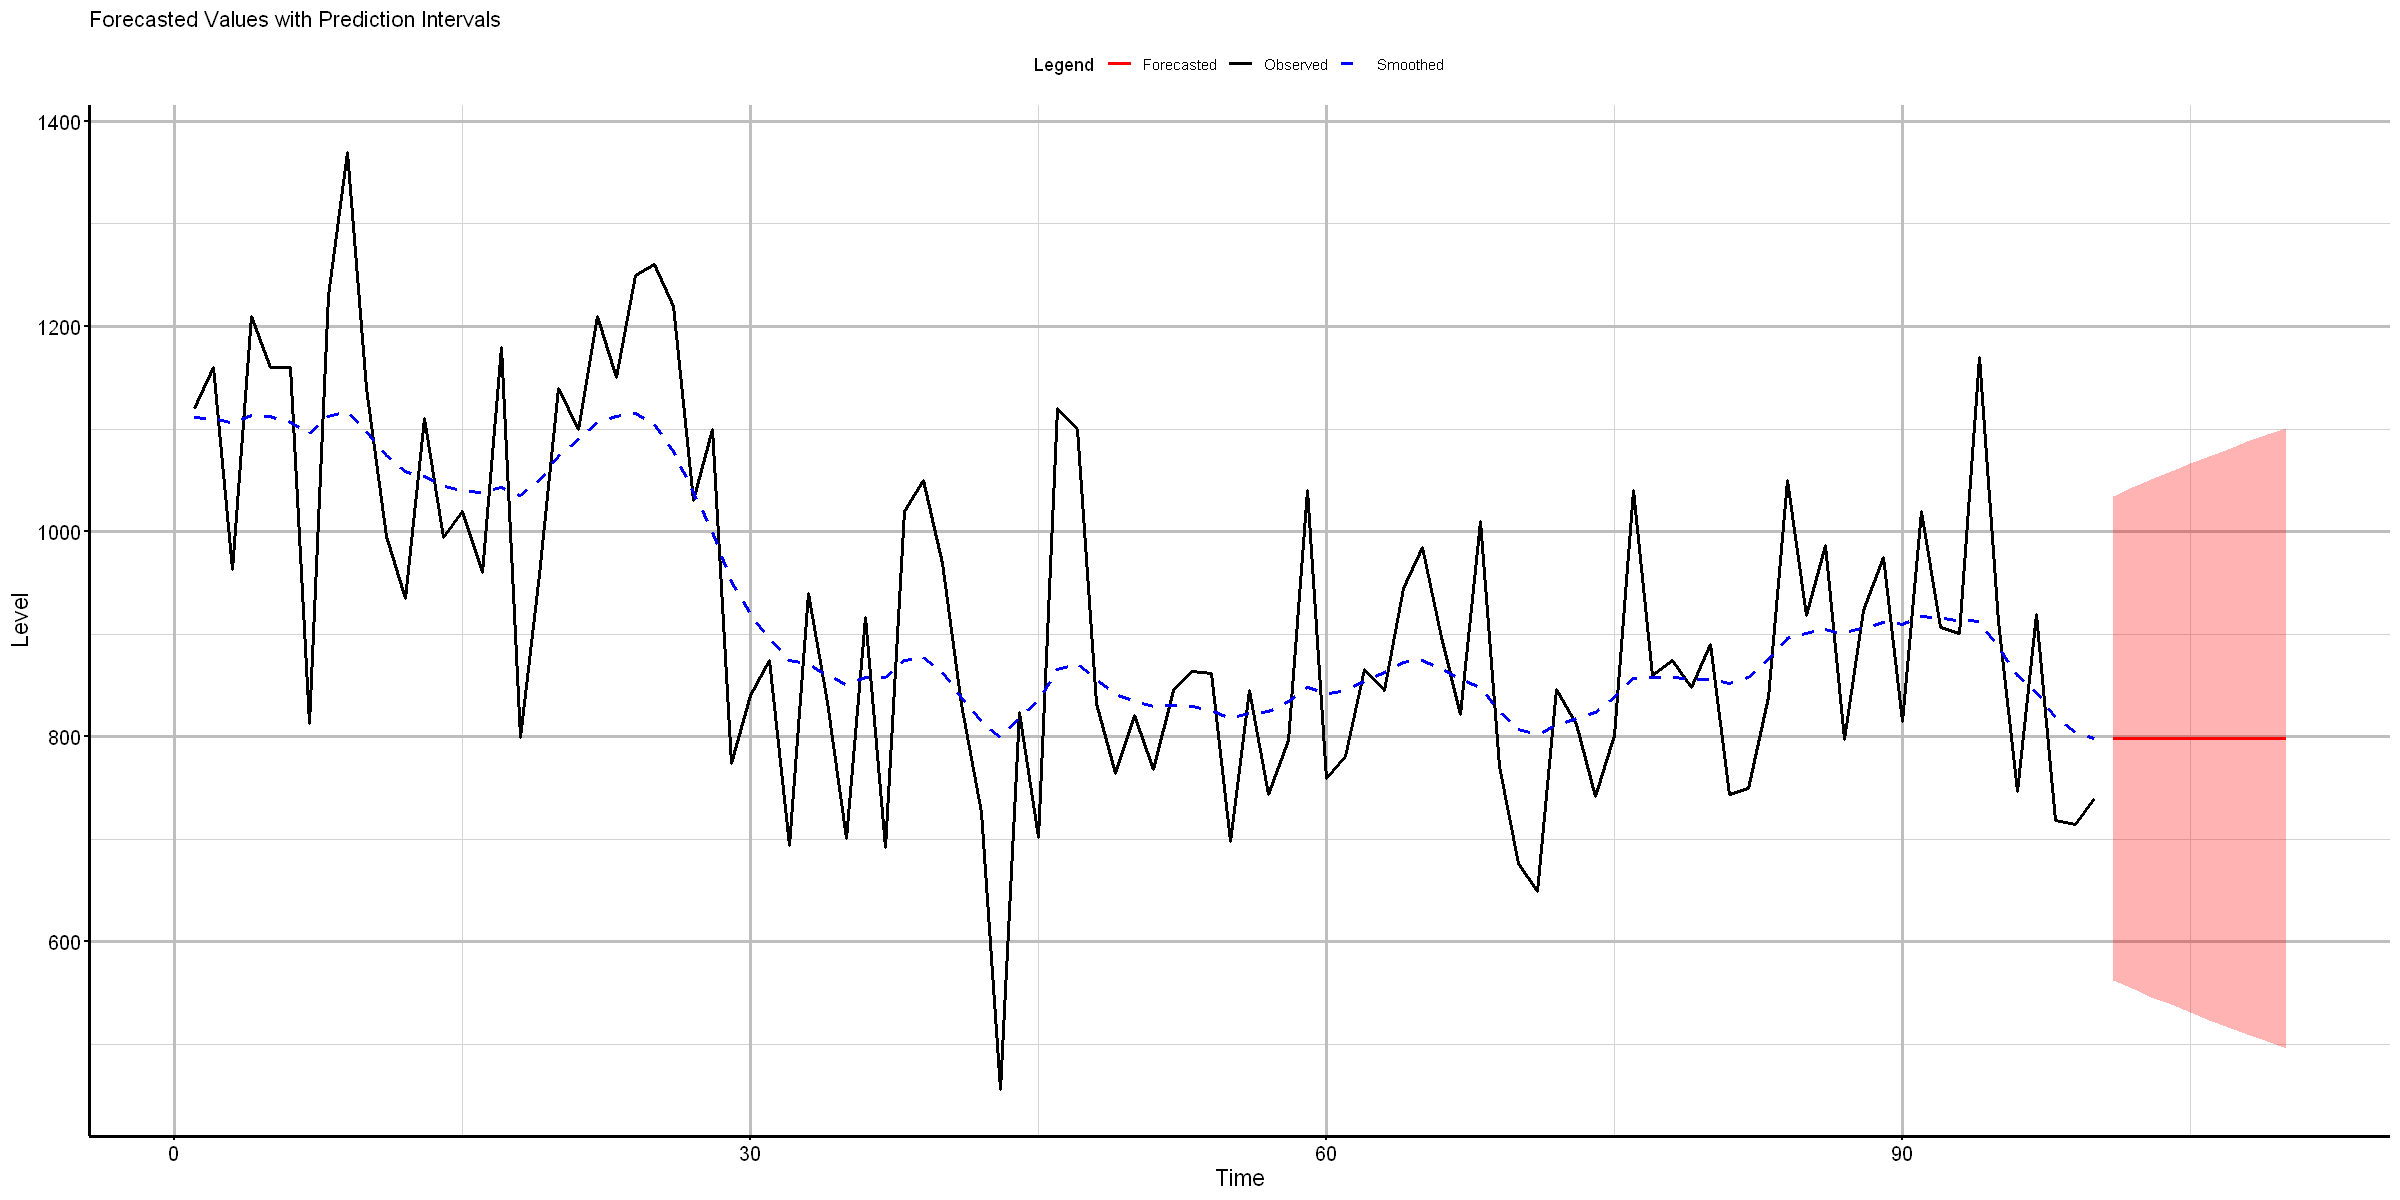

In [238]:
ggplot(df_forecast, aes(x = Time)) +
  # Adiciona as previsões como uma linha vermelha
  geom_line(aes(y = Forecasted, color = "Forecasted"), size = 1) +
  
  # Adiciona as bandas de previsão (intervalo de 50%)
  geom_ribbon(aes(ymin = Lower, ymax = Upper), fill = "red", alpha = 0.3) +
  
  # Adiciona as observações reais da série (y_mnl)
  geom_line(data = data.frame(Time = 1:length(Nile), Observed = Nile),
            aes(y = Observed, color = "Observed"), size = 1, linetype = "solid") +
  
  # Adiciona a linha de suavização (suavizado)
  geom_line(data = data.frame(Time = 1:length(smooth_Nile$s[-1]), Smoothed = smooth_Nile$s[-1]),
            aes(y = Smoothed, color = "Smoothed"), size = 1, linetype = "dashed") +
  
  # Personalizando os eixos e título
  labs(
    title = "Forecasted Values with Prediction Intervals",
    x = "Time",
    y = "Level",
    color = "Legend"
  ) +
  
  # Customizando a paleta de cores
  scale_color_manual(values = c("Forecasted" = "red", "Observed" = "black", "Smoothed" = "blue")) +
  
  # Tema minimalista
  theme_minimal() +
    theme(
    panel.grid.major = element_line(color = "gray", linewidth = 1),
    panel.grid.minor = element_line(color = "lightgray", linewidth = 0.5),
    axis.line = element_line(color = "black", linewidth = 1),  # Make axis lines thicker and black
    axis.ticks = element_line(color = "black", linewidth = 0.8),  # Make ticks more visible
    axis.text = element_text(size = 12, color = "black"),  # Adjust axis text size and color
    axis.title = element_text(size = 14, color = "black"),  # Adjust axis title size and color
    legend.position = "top")